In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)
file_path = '/Users/saikeerthan/NYP-AI/Year3/Ai_Solution_Development/Sai_Project/V3/master_dataset.csv'
df = pd.read_csv(file_path)

### Data preprocessing, Feature engineering and selection

In [3]:
print(df.isnull().sum())

order_id                            0
order_status                        0
order_purchase_timestamp            0
order_delivered_customer_date       0
customer_unique_id                  0
zip_code                            0
city                                0
state                               0
product_id                          0
seller_id                           0
price                               0
payment_type                        0
payment_installments                0
payment_value                       0
review_score                      722
product_category_name_english    1486
dtype: int64


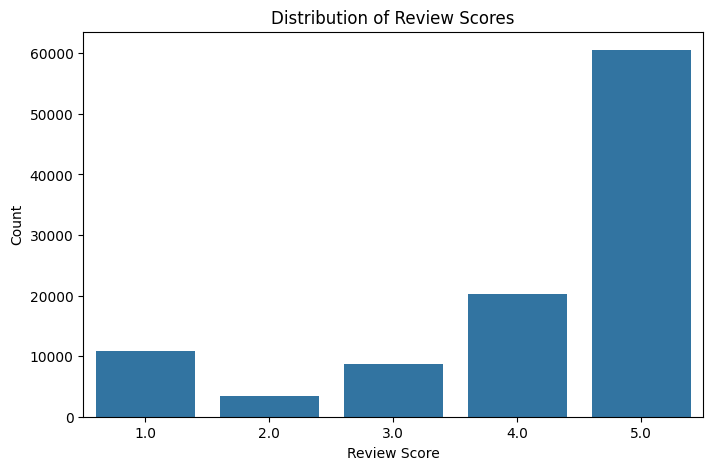

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='review_score', data=df)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

In [5]:
# Find the mode (most common value) for review_score
mode_value = df['review_score'].mode()[0]
# Fill missing values with the mode
df['review_score'] = df['review_score'].fillna(mode_value)

In [6]:
missing_cat = df[df['product_category_name_english'].isnull()]
print(missing_cat[['order_id', 'product_id', 'product_category_name_english']].head(10))

                             order_id                        product_id  \
113  bfe42c22ecbf90bc9f35cf591270b6a7  71225f49be70df4297892f6a5fa62171   
191  58ac1947c1a9067b9f416cba6d844a3f  9820e04e332fc450d6fd975befc1bc28   
241  e22b71f6e4a481445ec4527cb4c405f7  3bc5164bc7f4be77002d6651da65c98c   
278  a094215e786240fcfefb83d18036a1cd  5a848e4ab52fd5445cdc07aab1c40e48   
347  6f841dde94727854eaff3f66432c80ea  c600d7f13104e8db2ca2b9fa78581409   
489  66cf92fc3ec94fbafc4edd77e0814818  de6702c748c719cbd13bb814f006ba22   
546  769cad60df1d40dccfd5ec163be24654  26a4f62a409a78816adb31e0d729a163   
707  14d68c5b215a31950340dc9cb3f73efe  5a848e4ab52fd5445cdc07aab1c40e48   
736  1b99333d39cf95f48be3864b2e1e88b3  0ae10ca52e6cb8745e17c11e7c43907c   
963  8dbdb81783a3c754dc9441826510a36a  1954739d84629e7323a4295812a3e0ec   

    product_category_name_english  
113                           NaN  
191                           NaN  
241                           NaN  
278                           

In [7]:
# Drop rows where product_category_name_english is missing (NaN)
df = df.dropna(subset=['product_category_name_english'])
df = df.reset_index(drop=True)

In [8]:
print(df.isnull().sum())

order_id                         0
order_status                     0
order_purchase_timestamp         0
order_delivered_customer_date    0
customer_unique_id               0
zip_code                         0
city                             0
state                            0
product_id                       0
seller_id                        0
price                            0
payment_type                     0
payment_installments             0
payment_value                    0
review_score                     0
product_category_name_english    0
dtype: int64


In [9]:
# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


In [10]:
# # Save the cleaned DataFrame to CSV
# df.to_csv('/content/drive/MyDrive/EGT309 AI solution development project/cleaned_master_dataset_.csv', index=False)

In [11]:
# 1. Compute customer frequency for repeat buyer target
customer_orders = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.columns = ['customer_unique_id', 'order_count']

In [12]:
# 2. Merge back and create the target column
df = pd.merge(df, customer_orders, on='customer_unique_id', how='left')
df['is_repeat_buyer'] = df['order_count'].apply(lambda x: 1 if x > 1 else 0)

In [13]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
last_purchase = df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
now = df['order_purchase_timestamp'].max()
last_purchase['recency_days'] = (now - last_purchase['order_purchase_timestamp']).dt.days
df = pd.merge(df, last_purchase[['customer_unique_id', 'recency_days']], on='customer_unique_id', how='left')

In [14]:
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.dayofweek

In [15]:
df.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date            object
customer_unique_id                       object
zip_code                                  int64
city                                     object
state                                    object
product_id                               object
seller_id                                object
price                                   float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
review_score                            float64
product_category_name_english            object
order_count                               int64
is_repeat_buyer                           int64
recency_days                              int64
purchase_month                            int32
purchase_dayofweek                      

In [16]:
for col in ['product_category_name_english', 'payment_type', 'city', 'state']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [17]:
# 3. Select features for ML (now include new features)
features = [
    'price',
    'payment_type',
    'payment_installments',
    'payment_value',
    'review_score',
    'product_category_name_english',
    'zip_code',
    'city',
    'state',
    'recency_days',
    'purchase_month',
    'purchase_dayofweek'
]
X = df[features]
y = df['is_repeat_buyer']

In [18]:
# 6. Save processed features for future use if needed
# X.to_csv('/content/drive/MyDrive/EGT309 Project/prepared_ml_features.csv', index=False)
# y.to_csv('/content/drive/MyDrive/EGT309 Project/prepared_ml_target.csv', index=False)

In [19]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_delivered_customer_date,customer_unique_id,zip_code,city,state,product_id,seller_id,...,payment_type,payment_installments,payment_value,review_score,product_category_name_english,order_count,is_repeat_buyer,recency_days,purchase_month,purchase_dayofweek
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,1,1.0,18.12,4.0,49,2,1,331,10,0
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,4,1.0,2.00,4.0,49,2,1,331,10,0
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,7c396fd4830fd04220f754e42b4e5bff,3149,3554,25,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,...,4,1.0,18.59,4.0,49,2,1,331,10,0
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,af07308b275d755c9edb36a90c618231,47813,413,4,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,...,0,1.0,141.46,4.0,59,1,0,35,7,1
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,3a653a41f6f9fc3d2a113cf8398680e8,75265,4005,8,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,...,1,3.0,179.12,5.0,5,1,0,21,8,2


In [20]:
df.dtypes

order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_delivered_customer_date            object
customer_unique_id                       object
zip_code                                  int64
city                                      int64
state                                     int64
product_id                               object
seller_id                                object
price                                   float64
payment_type                              int64
payment_installments                    float64
payment_value                           float64
review_score                            float64
product_category_name_english             int64
order_count                               int64
is_repeat_buyer                           int64
recency_days                              int64
purchase_month                            int32
purchase_dayofweek                      

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True)

# Initial Model Training

In [22]:
clf = RandomForestClassifier()   #with default parameters

clf.fit(X_train,y_train)
acc = clf.score(X_test,y_test)
print('Accuracy:', acc)
print('Number of trees:', clf.n_estimators)

Accuracy: 0.9474435041986836
Number of trees: 100


In [23]:
y_train_pred =  clf.predict(X_train)
y_train_pred_prob =  clf.predict_proba(X_train)

In [24]:
y_train_pred

array([0, 0, 0, ..., 1, 0, 0], shape=(71966,))

In [25]:
y_train_pred_prob

array([[0.97, 0.03],
       [1.  , 0.  ],
       [0.99, 0.01],
       ...,
       [0.12, 0.88],
       [0.99, 0.01],
       [1.  , 0.  ]], shape=(71966, 2))

<Axes: xlabel='predict', ylabel='actual'>

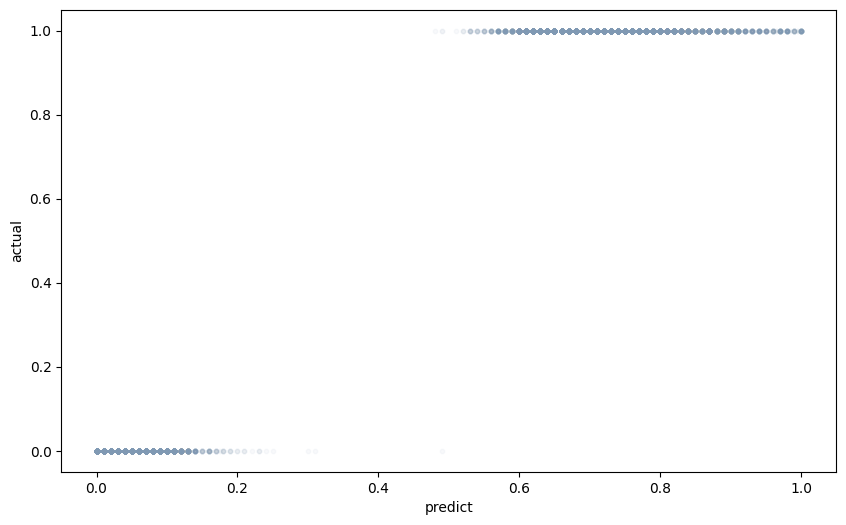

In [26]:
#Training Distribution map
y_train = y_train.replace(True, 1).replace(False, 0).astype(np.int64)
y_train_scores = y_train_pred_prob[:, 1]
train_predict = pd.DataFrame({'actual': y_train.values,
                              'predict': y_train_scores})
# train_predict
color =np.array([0.5, 0.6, 0.7]).reshape(1,-1)

train_predict.plot.scatter(x='predict', y='actual', s=10, alpha=0.05, figsize=(10,6), c= color)

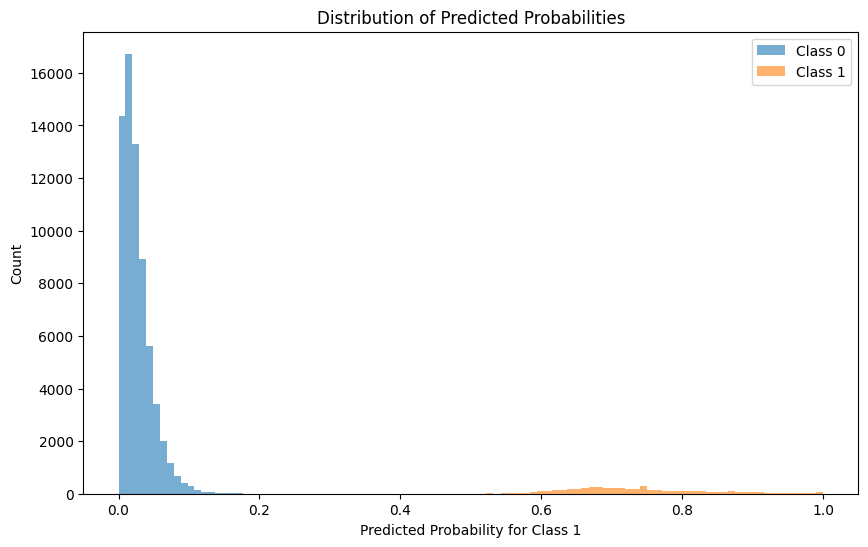

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_train_scores[y_train==0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_train_scores[y_train==1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores)

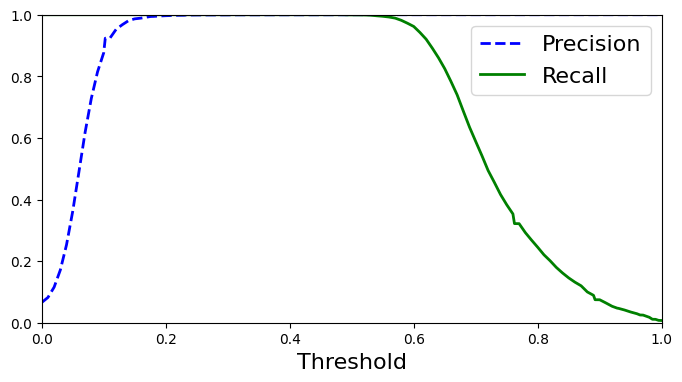

In [29]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper right", fontsize=16)
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

In [30]:
threshold = 0.2  # Or any value from your plot
y_pred_custom = (y_train_scores > threshold).astype(int)
print(classification_report(y_train, y_pred_custom))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67243
           1       1.00      1.00      1.00      4723

    accuracy                           1.00     71966
   macro avg       1.00      1.00      1.00     71966
weighted avg       1.00      1.00      1.00     71966



## Trying on test set

In [31]:
y_test_pred_prob = clf.predict_proba(X_test)
y_test_pred_prob

array([[0.92, 0.08],
       [0.91, 0.09],
       [1.  , 0.  ],
       ...,
       [1.  , 0.  ],
       [0.89, 0.11],
       [0.94, 0.06]], shape=(30843, 2))

In [32]:
y_test_scores = y_test_pred_prob[:, 1]
y_test_scores

array([0.08, 0.09, 0.  , ..., 0.  , 0.11, 0.06], shape=(30843,))

In [33]:
threshold = 0.2
y_pred_test_custom = (y_test_scores > threshold).astype(int)

# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test_custom))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     28847
           1       0.68      0.49      0.57      1996

    accuracy                           0.95     30843
   macro avg       0.82      0.74      0.77     30843
weighted avg       0.95      0.95      0.95     30843



## Find best threshold

In [34]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Get predicted probabilities for class 1
y_test_scores = clf.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_scores)

# Compute F1 for each threshold
f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Exclude last value (thresholds is len-1 of precisions/recalls)
best_idx = np.argmax(f1s[:-1])
best_threshold = thresholds[best_idx]
best_f1 = f1s[best_idx]

print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.3f}")

# Predict using the best threshold
y_pred_best_thresh = (y_test_scores > best_threshold).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best_thresh))

Best threshold for F1: 0.210
Best F1 score: 0.569
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28847
           1       0.73      0.46      0.57      1996

    accuracy                           0.95     30843
   macro avg       0.85      0.73      0.77     30843
weighted avg       0.95      0.95      0.95     30843



In [35]:
for t in np.arange(0.1, 0.5, 0.05):
    y_pred = (y_test_scores > t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    print(f"Threshold: {t:.2f}, Recall for class 1: {report['1']['recall']:.3f}, Precision: {report['1']['precision']:.3f}, F1: {report['1']['f1-score']:.3f}")

Threshold: 0.10, Recall for class 1: 0.684, Precision: 0.247, F1: 0.363
Threshold: 0.15, Recall for class 1: 0.564, Precision: 0.456, F1: 0.504
Threshold: 0.20, Recall for class 1: 0.483, Precision: 0.693, F1: 0.569
Threshold: 0.25, Recall for class 1: 0.415, Precision: 0.837, F1: 0.555
Threshold: 0.30, Recall for class 1: 0.358, Precision: 0.938, F1: 0.518
Threshold: 0.35, Recall for class 1: 0.303, Precision: 0.970, F1: 0.462
Threshold: 0.40, Recall for class 1: 0.265, Precision: 0.981, F1: 0.417
Threshold: 0.45, Recall for class 1: 0.223, Precision: 0.991, F1: 0.364


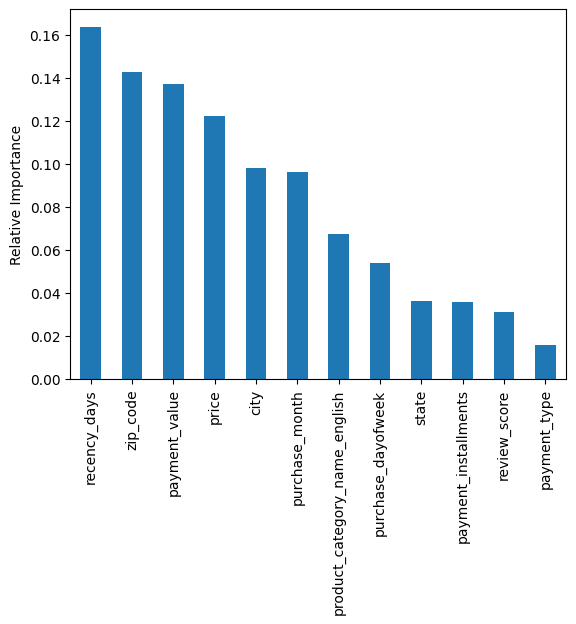

In [36]:
#feature importance
feature_imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
fig = plt.figure()
ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');

## Fine-tuning Hyperparameters

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [20,30,40],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [2, 4, 6],
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid = GridSearchCV(
    rf,
    param_grid,
    scoring='f1',
    cv=2,
    verbose=2,
    n_jobs=-1
)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1 score:", grid.best_score_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  19.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=  19.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  19.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  20.2s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  26.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=  27.3s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  33.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  34.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  27.1s
[CV] END max_depth=20, min_sa

KeyboardInterrupt: 

In [ ]:
train_pred = grid.predict(X_train)
test_pred = grid.predict(X_test)

from sklearn.metrics import f1_score

print("Training F1:", f1_score(y_train, train_pred, pos_label=1))
print("Test F1:", f1_score(y_test, test_pred, pos_label=1))

Training F1: 0.15822291504286828
Test F1: 0.06298449612403101


In [ ]:
for depth in [10, 15, 20]:
    for leaf in [2, 4, 8]:
        clf2 = RandomForestClassifier(
            n_estimators=100,
            max_depth=depth,
            min_samples_leaf=leaf,
            min_samples_split=2,
            random_state=42
        )
        clf2.fit(X_train, y_train)
        train_f1 = f1_score(y_train, clf2.predict(X_train), pos_label=1)
        test_f1 = f1_score(y_test, clf2.predict(X_test), pos_label=1)
        print(f"Depth: {depth}, Min leaf: {leaf} --> Train F1: {train_f1:.3f}, Test F1: {test_f1:.3f}")


Depth: 10, Min leaf: 2 --> Train F1: 0.028, Test F1: 0.011
Depth: 10, Min leaf: 4 --> Train F1: 0.025, Test F1: 0.012
Depth: 10, Min leaf: 8 --> Train F1: 0.018, Test F1: 0.005
Depth: 15, Min leaf: 2 --> Train F1: 0.158, Test F1: 0.064
Depth: 15, Min leaf: 4 --> Train F1: 0.093, Test F1: 0.038
Depth: 15, Min leaf: 8 --> Train F1: 0.054, Test F1: 0.026
Depth: 20, Min leaf: 2 --> Train F1: 0.365, Test F1: 0.124
Depth: 20, Min leaf: 4 --> Train F1: 0.198, Test F1: 0.073
Depth: 20, Min leaf: 8 --> Train F1: 0.084, Test F1: 0.040


In [ ]:
y_proba = clf2.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_proba > 0.2).astype(int)
print(f1_score(y_test, y_pred_thresh, pos_label=1))


0.3561859732072498


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Use your best engineered features in X_train, X_test

param_grid = {
    'n_estimators': [500, 700, 900],
    'max_depth': [20,25,30],
    'min_samples_leaf': [7,10],
    'min_samples_split': [7,10],
    'max_features': ['sqrt'],
}

rf = RandomForestClassifier(class_weight = 'balanced' , random_state=42, n_jobs=-1)
grid1 = GridSearchCV(
    rf,
    param_grid,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1
)
grid1.fit(X_train, y_train)

print("Best parameters:", grid1.best_params_)
print("Best F1 score (CV):", grid1.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 7, 'n_estimators': 700}
Best F1 score (CV): 0.2187149134606762


In [ ]:
# Evaluate on test set
from sklearn.metrics import classification_report

y_test_pred_proba = grid1.best_estimator_.predict_proba(X_test)[:, 1]
best_thresh = 0.2   # Or use your best found threshold
y_test_pred = (y_test_pred_proba > best_thresh).astype(int)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.26      0.41     28847
           1       0.08      0.93      0.15      1996

    accuracy                           0.30     30843
   macro avg       0.53      0.60      0.28     30843
weighted avg       0.92      0.30      0.39     30843



# LightGBM

In [ ]:
print(X.dtypes)

price                            float64
payment_type                       int64
payment_installments             float64
payment_value                    float64
review_score                     float64
product_category_name_english      int64
zip_code                           int64
city                               int64
state                              int64
recency_days                       int64
purchase_month                     int32
purchase_dayofweek                 int32
dtype: object


In [ ]:
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report

# Create and train the model
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(X_train, y_train)

# Predict probabilities for threshold tuning
y_proba = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 4723, number of negative: 67243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002722 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 71966, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
F1-score: 0.1433558473097063
              precision    recall  f1-score   support

           0       0.98      0.22      0.36     28847
           1       0.08      0.95      0.14      1996

    accuracy                           0.27     30843
   macro avg       0.53      0.58      0.25     30843
weighted avg       0.92      0.27      0.35     30843



In [ ]:
# Try your best threshold (e.g., 0.2)
threshold = 0.6
y_pred_thresh = (y_proba > threshold).astype(int)

# Evaluate
print("F1-score:", f1_score(y_test, y_pred_thresh, pos_label=1))
print(classification_report(y_test, y_pred_thresh))

F1-score: 0.46601941747572817
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     28847
           1       0.50      0.43      0.47      1996

    accuracy                           0.94     30843
   macro avg       0.73      0.70      0.72     30843
weighted avg       0.93      0.94      0.93     30843



In [ ]:
y_test_scores = y_proba  # Probabilities for class 1

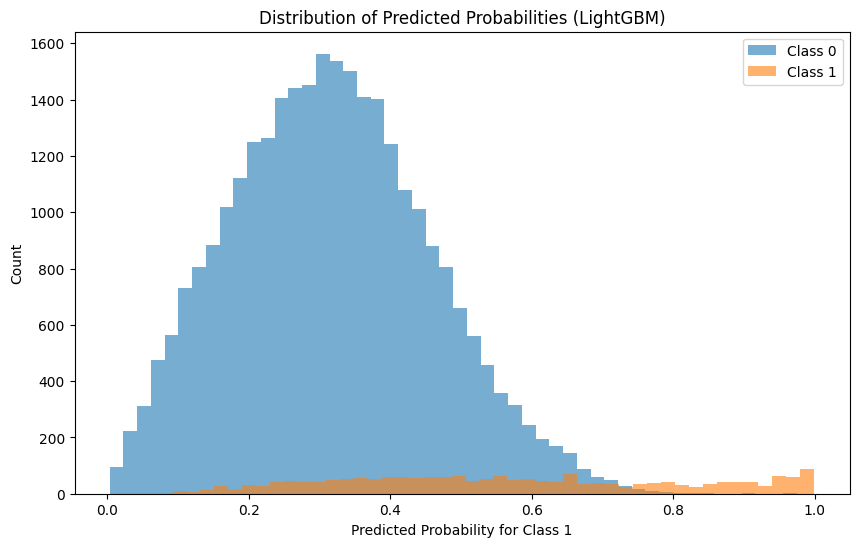

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_test_scores[y_test == 0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_test_scores[y_test == 1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities (LightGBM)')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()

# Optimization

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import numpy as np

# Calculate scale_pos_weight
scale_weight = (y_train == 0).sum() / (y_train == 1).sum()

param_grid = {
    'num_leaves': [7, 15, 31, 63, 127],
    'max_depth': [3, 5, 7, 10, 15],
    'min_child_samples': [5, 10, 20, 50, 100],
    'scale_pos_weight': [1, 3, 7, 10, int(scale_weight)],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'class_weight': ['balanced']
}

lgbm = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1
)

rs = RandomizedSearchCV(
    lgbm,
    param_distributions=param_grid,
    n_iter=30,          # Try more for thorough search
    scoring='f1',       # Or use make_scorer for class 1 only
    cv=3,
    verbose=2,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV F1:", rs.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 4723, number of negative: 67243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1423
[LightGBM] [Info] Number of data points in the train set: 71966, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
from sklearn.metrics import classification_report, f1_score

# 1. Retrieve best model
best_lgbm = rs.best_estimator_

# 2. Predict probabilities for threshold tuning
y_train_proba = best_lgbm.predict_proba(X_train)[:, 1]
y_test_proba = best_lgbm.predict_proba(X_test)[:, 1]

In [ ]:
# 3. Choose your best threshold (start with 0.2 or sweep for optimal value)
threshold = 0.5

y_train_pred = (y_train_proba > threshold).astype(int)
y_test_pred = (y_test_proba > threshold).astype(int)

# 4. Print metrics for training set
print("=== TRAINING SET ===")
print(f"F1-score: {f1_score(y_train, y_train_pred, pos_label=1):.3f}")
print(classification_report(y_train, y_train_pred))

# 5. Print metrics for test set
print("=== TEST SET ===")
print(f"F1-score: {f1_score(y_test, y_test_pred, pos_label=1):.3f}")
print(classification_report(y_test, y_test_pred))

=== TRAINING SET ===
F1-score: 0.508
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     67243
           1       0.37      0.81      0.51      4723

    accuracy                           0.90     71966
   macro avg       0.68      0.86      0.73     71966
weighted avg       0.95      0.90      0.91     71966

=== TEST SET ===
F1-score: 0.353
              precision    recall  f1-score   support

           0       0.97      0.89      0.92     28847
           1       0.26      0.57      0.35      1996

    accuracy                           0.87     30843
   macro avg       0.61      0.73      0.64     30843
weighted avg       0.92      0.87      0.89     30843



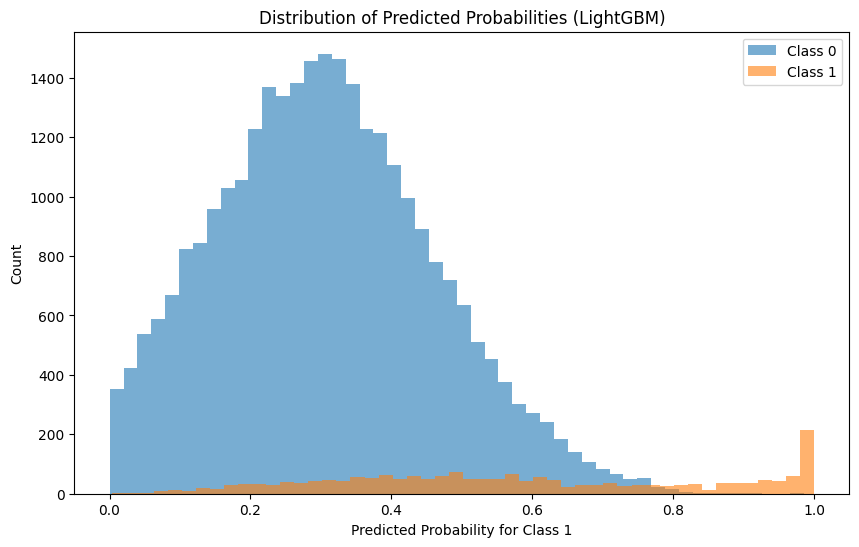

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(y_test_proba[y_test == 0], bins=50, alpha=0.6, label='Class 0')
plt.hist(y_test_proba[y_test == 1], bins=50, alpha=0.6, label='Class 1')
plt.title('Distribution of Predicted Probabilities (LightGBM)')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Count')
plt.legend()
plt.show()

## Sai's Model Training

Jun Ming has trained his Random Forest and his LightGBM model, which returned decent overall accuracy scores, but a noticeable trait about his models is that they predict the non-buyer class (class 0) better than the repeat-buyer class (Class 1), which does not really align with our project objectives, which is to predict which are the repeat-buyers. 

Therefore, the current plan is to train a Model to predict better on the repeat-buyer class (Class 1), and then fuse it with Jun Ming's best model, to create an ultimate ensemble model which will predict all the classes fairly with decent accuracy. 

### XGBoost 

In [51]:
print(X.columns)

Index(['price', 'payment_type', 'payment_installments', 'payment_value',
       'review_score', 'product_category_name_english', 'zip_code', 'city',
       'state', 'recency_days', 'purchase_month', 'purchase_dayofweek'],
      dtype='object')


In [ ]:
# First split off test set (20%)
X_temp, X_test_sai, y_temp, y_test_sai = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train_sai, X_val_sai, y_train_sai, y_val_sai = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
print(f"Train: {X_train_sai.shape}, Val: {X_val_sai.shape}, Test: {X_test_sai.shape}")

Train: (61685, 12), Val: (20562, 12), Test: (20562, 12)


In [59]:
categorical_features = X_train_sai.select_dtypes(include=['object']).columns.tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Copy your split data
X_train_sai_xgb = X_train_sai.copy()
X_val_sai_xgb = X_val_sai.copy()
X_test_sai_xgb = X_test_sai.copy()

label_encoders = {}

# Use the categorical_features list you already have
for col in categorical_features:
    le = LabelEncoder()
    X_train_sai_xgb[col] = le.fit_transform(X_train_sai[col].astype(str))
    X_val_sai_xgb[col] = le.transform(X_val_sai[col].astype(str))
    X_test_sai_xgb[col] = le.transform(X_test_sai[col].astype(str))
    label_encoders[col] = le

In [61]:
# to heavily prefer class 1 we will calculate the class weights for that to happen through collections 

from collections import Counter 

counter_sai = Counter(y_train_sai)
weight_0 = 1.0 
weight_1 = counter_sai[0] / counter_sai[1] 

In [62]:
# check the class weights 

print("Weight of Class 0", weight_0)
print("Weight of Class 1", weight_1)

Weight of Class 0 1.0
Weight of Class 1 14.302654428181592


as seen above, we have tuned the model such that it can heavily prefer class 1 instead of class 0, we will now continue to fit the XGBoost Model to the train

In [71]:
from xgboost import XGBClassifier

xgb_sai = XGBClassifier(
    scale_pos_weight=weight_1,       # This biases towards class 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_sai.fit(X_train_sai_xgb, y_train_sai, eval_set=[(X_val_sai_xgb, y_val_sai)],verbose=True)

[0]	validation_0-logloss:0.69190
[1]	validation_0-logloss:0.69047
[2]	validation_0-logloss:0.68902
[3]	validation_0-logloss:0.68777
[4]	validation_0-logloss:0.68627
[5]	validation_0-logloss:0.68515
[6]	validation_0-logloss:0.68316
[7]	validation_0-logloss:0.68102
[8]	validation_0-logloss:0.67989
[9]	validation_0-logloss:0.67854
[10]	validation_0-logloss:0.67716
[11]	validation_0-logloss:0.67588
[12]	validation_0-logloss:0.67462
[13]	validation_0-logloss:0.67322
[14]	validation_0-logloss:0.67209
[15]	validation_0-logloss:0.67077
[16]	validation_0-logloss:0.66939
[17]	validation_0-logloss:0.66807
[18]	validation_0-logloss:0.66680
[19]	validation_0-logloss:0.66544
[20]	validation_0-logloss:0.66423
[21]	validation_0-logloss:0.66124
[22]	validation_0-logloss:0.65970
[23]	validation_0-logloss:0.65903
[24]	validation_0-logloss:0.65816
[25]	validation_0-logloss:0.65738
[26]	validation_0-logloss:0.65656
[27]	validation_0-logloss:0.65586
[28]	validation_0-logloss:0.65532
[29]	validation_0-loglos

/Users/saikeerthan/NYP-AI/Year3/new_y3s1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:35:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[66]	validation_0-logloss:0.61973
[67]	validation_0-logloss:0.61901
[68]	validation_0-logloss:0.61768
[69]	validation_0-logloss:0.61708
[70]	validation_0-logloss:0.61670
[71]	validation_0-logloss:0.61559
[72]	validation_0-logloss:0.61486
[73]	validation_0-logloss:0.61443
[74]	validation_0-logloss:0.61402
[75]	validation_0-logloss:0.61238
[76]	validation_0-logloss:0.61187
[77]	validation_0-logloss:0.61153
[78]	validation_0-logloss:0.61111
[79]	validation_0-logloss:0.61053
[80]	validation_0-logloss:0.61016
[81]	validation_0-logloss:0.60955
[82]	validation_0-logloss:0.60909
[83]	validation_0-logloss:0.60674
[84]	validation_0-logloss:0.60632
[85]	validation_0-logloss:0.60582
[86]	validation_0-logloss:0.60525
[87]	validation_0-logloss:0.60482
[88]	validation_0-logloss:0.60423
[89]	validation_0-logloss:0.60352
[90]	validation_0-logloss:0.60304
[91]	validation_0-logloss:0.60226
[92]	validation_0-logloss:0.59996
[93]	validation_0-logloss:0.59948
[94]	validation_0-logloss:0.59900
[95]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

### Evaluate XGBoost Results:

In [72]:
y_val_probs = xgb_sai.predict_proba(X_val_sai_xgb)[:, 1]
y_test_probs = xgb_sai.predict_proba(X_test_sai_xgb)[:, 1]
y_train_probs = xgb_sai.predict_proba(X_train_sai_xgb)[:, 1]

In [82]:
threshold = 0.2 # set the threshold to 0.5 for now

In [83]:
y_val_preds = (y_val_probs > threshold).astype(int)
y_test_preds = (y_test_probs > threshold).astype(int)
y_train_preds = (y_train_probs > threshold).astype(int)

In [84]:
# results in classification report
print("=== TRAIN SET ===")
print(classification_report(y_train_sai, y_train_preds, digits=3))

print("\n=== VALIDATION SET ===")
print(classification_report(y_val_sai, y_val_preds, digits=3))

print("\n=== TEST SET ===")
print(classification_report(y_test_sai, y_test_preds, digits=3))

=== TRAIN SET ===
              precision    recall  f1-score   support

           0      1.000     0.175     0.297     57654
           1      0.078     1.000     0.145      4031

    accuracy                          0.229     61685
   macro avg      0.539     0.587     0.221     61685
weighted avg      0.940     0.229     0.287     61685


=== VALIDATION SET ===
              precision    recall  f1-score   support

           0      0.984     0.166     0.283     19218
           1      0.075     0.961     0.138      1344

    accuracy                          0.218     20562
   macro avg      0.529     0.563     0.211     20562
weighted avg      0.924     0.218     0.274     20562


=== TEST SET ===
              precision    recall  f1-score   support

           0      0.984     0.162     0.278     19218
           1      0.074     0.962     0.138      1344

    accuracy                          0.214     20562
   macro avg      0.529     0.562     0.208     20562
weighted avg  

In [85]:
for t in [0.5, 0.4, 0.3, 0.25]:
    preds = (y_val_probs > t).astype(int)
    print(f"\n--- Threshold: {t} ---")
    print(classification_report(y_val_sai, preds, digits=3))


--- Threshold: 0.5 ---
              precision    recall  f1-score   support

           0      0.966     0.888     0.925     19218
           1      0.256     0.551     0.349      1344

    accuracy                          0.866     20562
   macro avg      0.611     0.719     0.637     20562
weighted avg      0.919     0.866     0.888     20562


--- Threshold: 0.4 ---
              precision    recall  f1-score   support

           0      0.973     0.701     0.815     19218
           1      0.145     0.725     0.242      1344

    accuracy                          0.703     20562
   macro avg      0.559     0.713     0.528     20562
weighted avg      0.919     0.703     0.778     20562


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0      0.979     0.416     0.584     19218
           1      0.094     0.871     0.170      1344

    accuracy                          0.446     20562
   macro avg      0.537     0.644     0.377     20562
we

### Fine Tuning Round 1: 

Our biggest enemy now is the Imbalanced Class, which is Class 1, and since the entire project revolves around trying to accurately predict Class 1, we will try to improve the XGboost model to predict Class 1 better. One way is to carry out SMOTE and Undersample some of Class 0 as the number of sets for Class 0 is way more than Class 1, especially after the complicated logic which was inserted during data pre-processing. 

Lastly, after SMOTE & UnderSampling, we will attach a meta-learner, Logistic Regression, which will help to further boost the results

In [86]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# setting up the imbalanced learn pipeline

smote_sai = SMOTE(random_state=42)
under_sai = RandomUnderSampler(random_state=42)
steps = [('o', smote_sai), ('u', under_sai)]
pipeline_sai = Pipeline(steps=steps)

# resample the training set 

X_train_smote, y_train_smote = pipeline_sai.fit_resample(X_train_sai_xgb, y_train_sai)


In [87]:
# check the resampled class distribution 

print("Resamples X Tensor Shape:", X_train_smote.shape)
print("Resampled y Tensor Shape:", y_train_smote.shape)
print("Resampled Class Distribution:", Counter(y_train_smote))

Resamples X Tensor Shape: (115308, 12)
Resampled y Tensor Shape: (115308,)
Resampled Class Distribution: Counter({0: 57654, 1: 57654})


#### Train Logistic Regression:

In [89]:
from sklearn.linear_model import LogisticRegression

lr_sai = LogisticRegression(
    max_iter=1000, 
    class_weight=None,  # don't need to set class weights as they have been taken care of by SMOTE
    solver='liblinear', 
    random_state=42
)

lr_sai.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

#### Train another XGBoost on Balanced Set

In [90]:
from xgboost import XGBClassifier

xgb_smote = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_smote.fit(X_train_smote, y_train_smote)

/Users/saikeerthan/NYP-AI/Year3/new_y3s1/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:51:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### Evaluate Both Models

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Logistic Regression ---

# Train set predictions
lr_train_probs = lr_sai.predict_proba(X_train_sai_xgb)[:, 1]
lr_train_preds = (lr_train_probs > threshold).astype(int)

# Validation set predictions
lr_val_probs = lr_sai.predict_proba(X_val_sai_xgb)[:, 1]
lr_val_preds = (lr_val_probs > threshold).astype(int)

# --- XGBoost ---

# Train set predictions
xgb_train_probs = xgb_smote.predict_proba(X_train_sai_xgb)[:, 1]
xgb_train_preds = (xgb_train_probs > threshold).astype(int)

# Validation set predictions
xgb_val_probs = xgb_smote.predict_proba(X_val_sai_xgb)[:, 1]
xgb_val_preds = (xgb_val_probs > threshold).astype(int)



In [99]:
print("=== Logistic Regression: TRAIN SET ===")
print(classification_report(y_train_sai, lr_train_preds, digits=3))


print("\n=== Logistic Regression: VAL SET ===")
print(classification_report(y_val_sai, lr_val_preds, digits=3))

print("")
print("-----------------------------------")
print("")
print("\n=== XGBoost: TRAIN SET ===")
print(classification_report(y_train_sai, xgb_train_preds, digits=3))


print("\n=== XGBoost: VAL SET ===")
print(classification_report(y_val_sai, xgb_val_preds, digits=3))


=== Logistic Regression: TRAIN SET ===
              precision    recall  f1-score   support

           0      0.942     0.570     0.710     57654
           1      0.076     0.503     0.131      4031

    accuracy                          0.565     61685
   macro avg      0.509     0.536     0.421     61685
weighted avg      0.886     0.565     0.672     61685


=== Logistic Regression: VAL SET ===
              precision    recall  f1-score   support

           0      0.942     0.567     0.708     19218
           1      0.075     0.501     0.130      1344

    accuracy                          0.562     20562
   macro avg      0.508     0.534     0.419     20562
weighted avg      0.885     0.562     0.670     20562


-----------------------------------


=== XGBoost: TRAIN SET ===
              precision    recall  f1-score   support

           0      0.961     0.997     0.978     57654
           1      0.909     0.414     0.569      4031

    accuracy                          0

XGBoost has benefitted greatly from the SMOTE + Undersampling Round, let us experiment by playing with the threshold values

In [101]:
from sklearn.metrics import classification_report

# Predict probabilities on validation set using the XGBoost model trained on the SMOTE+undersample data
xgb_val_probs = xgb_smote.predict_proba(X_val_sai_xgb)[:, 1]

for t in [0.4, 0.3, 0.25]:
    preds = (xgb_val_probs > t).astype(int)
    print(f"\n--- Threshold: {t} ---")
    print(classification_report(y_val_sai, preds, digits=3))


--- Threshold: 0.4 ---
              precision    recall  f1-score   support

           0      0.956     0.986     0.971     19218
           1      0.636     0.357     0.457      1344

    accuracy                          0.945     20562
   macro avg      0.796     0.671     0.714     20562
weighted avg      0.935     0.945     0.937     20562


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0      0.958     0.966     0.962     19218
           1      0.449     0.394     0.420      1344

    accuracy                          0.929     20562
   macro avg      0.704     0.680     0.691     20562
weighted avg      0.925     0.929     0.927     20562


--- Threshold: 0.25 ---
              precision    recall  f1-score   support

           0      0.960     0.943     0.952     19218
           1      0.350     0.436     0.388      1344

    accuracy                          0.910     20562
   macro avg      0.655     0.690     0.670     20562
w

even though we played with the threshold, we still think that the XGBoost with the SMOTE + Undersampling is our best model. Even though lowering the threshold catches more repeated buyers, we still strive for precision, and therefore we think that in the business case scenario, in order to save up on costs on targeted marketing campaigns, it will be best to take the model with the highest precision, even though it is compromising on recall and f1 score. 

In [120]:
# Save the XGBoost SMOTE + UnderSampling Model

#joblib version: 
import joblib 
joblib.dump(xgb_smote, 'xgb_smote_model.pkl')

['xgb_smote_model.pkl']

In [123]:
# xgboost version(JSON):
xgb_smote.save_model('xgb_smote_model.json')

We can try to stack the Logistic Regression and the XGBoost Model Together

In [103]:
# For stacking, use predicted probabilities as features
xgb_val_probs = xgb_smote.predict_proba(X_val_sai_xgb)[:, 1]
lr_val_probs  = lr_sai.predict_proba(X_val_sai_xgb)[:, 1]

import numpy as np
stack_val = np.column_stack((xgb_val_probs, lr_val_probs))

In [109]:
xgb_train_probs = xgb_smote.predict_proba(X_train_sai_xgb)[:, 1]
lr_train_probs  = lr_sai.predict_proba(X_train_sai_xgb)[:, 1]

stack_train = np.column_stack((xgb_train_probs, lr_train_probs))

# do the same for test set 
xgb_test_probs = xgb_smote.predict_proba(X_test_sai_xgb)[:, 1]
lr_test_probs  = lr_sai.predict_proba(X_test_sai_xgb)[:, 1]

stack_test = np.column_stack((xgb_test_probs, lr_test_probs))

In [106]:
from sklearn.linear_model import LogisticRegression

meta_lr = LogisticRegression(max_iter=1000, random_state=42)
meta_lr.fit(stack_train, y_train_sai)

LogisticRegression(max_iter=1000, random_state=42)

In [110]:
stack_val_probs = meta_lr.predict_proba(stack_val)[:, 1]

# Tune threshold as before (start with 0.5)
threshold = 0.5
stack_val_preds = (stack_val_probs > threshold).astype(int)

stack_test_probs = meta_lr.predict_proba(stack_test)[:, 1]
stack_test_preds = (stack_test_probs > threshold).astype(int)

from sklearn.metrics import classification_report
print("=== Stacked Model (Meta-Logistic Regression) on VAL SET ===")
print(classification_report(y_val_sai, stack_val_preds, digits=3))
print("\n")
print("=== Stacked Model (Meta-Logistic Regression) on TEST SET ===")
print(classification_report(y_test_sai, stack_test_preds, digits=3))

=== Stacked Model (Meta-Logistic Regression) on VAL SET ===
              precision    recall  f1-score   support

           0      0.956     0.991     0.973     19218
           1      0.727     0.342     0.465      1344

    accuracy                          0.949     20562
   macro avg      0.842     0.666     0.719     20562
weighted avg      0.941     0.949     0.940     20562



=== Stacked Model (Meta-Logistic Regression) on TEST SET ===
              precision    recall  f1-score   support

           0      0.955     0.991     0.972     19218
           1      0.714     0.327     0.448      1344

    accuracy                          0.947     20562
   macro avg      0.834     0.659     0.710     20562
weighted avg      0.939     0.947     0.938     20562



In [111]:
for t in [0.4, 0.3, 0.25]:
    preds = (stack_val_probs > t).astype(int)
    print(f"\n--- Threshold: {t} ---")
    print(classification_report(y_val_sai, preds, digits=3))


--- Threshold: 0.4 ---
              precision    recall  f1-score   support

           0      0.956     0.987     0.972     19218
           1      0.661     0.356     0.463      1344

    accuracy                          0.946     20562
   macro avg      0.809     0.671     0.717     20562
weighted avg      0.937     0.946     0.938     20562


--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0      0.957     0.981     0.969     19218
           1      0.583     0.370     0.452      1344

    accuracy                          0.941     20562
   macro avg      0.770     0.676     0.711     20562
weighted avg      0.933     0.941     0.935     20562


--- Threshold: 0.25 ---
              precision    recall  f1-score   support

           0      0.957     0.977     0.967     19218
           1      0.532     0.376     0.440      1344

    accuracy                          0.938     20562
   macro avg      0.744     0.676     0.704     20562
w

### Training CatBoost:

In [ ]:
cat_features = X_train_sai.select_dtypes(include='object').columns.tolist()

In [116]:
from collections import Counter
counter = Counter(y_train_sai)
weight_0 = 1.0
weight_1 = counter[0] / counter[1]
print(f"CatBoost class weights: [1.0, {weight_1}]")

CatBoost class weights: [1.0, 14.302654428181592]


In [117]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    class_weights=[weight_0, weight_1],
    random_state=42,
    cat_features=cat_features,
    verbose=100,
    early_stopping_rounds=50
)

cat_model.fit(X_train_sai, y_train_sai, eval_set=(X_val_sai, y_val_sai))

0:	learn: 0.4649198	test: 0.4868742	best: 0.4868742 (0)	total: 61.6ms	remaining: 1m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.604870387
bestIteration = 24

Shrink model to first 25 iterations.


In [119]:
cat_val_probs = cat_model.predict_proba(X_val_sai)[:, 1]
cat_train_probs = cat_model.predict_proba(X_train_sai)[:, 1]

threshold = 0.5
cat_val_preds = (cat_val_probs > threshold).astype(int)
cat_train_preds = (cat_train_probs > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("=== CatBoost: TRAIN SET ===")
print(classification_report(y_train_sai, cat_train_preds, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_train_sai, cat_train_preds))

print("\n=== CatBoost: VAL SET ===")
print(classification_report(y_val_sai, cat_val_preds, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_val_sai, cat_val_preds))

=== CatBoost: TRAIN SET ===
              precision    recall  f1-score   support

           0      0.959     0.717     0.821     57654
           1      0.122     0.561     0.200      4031

    accuracy                          0.707     61685
   macro avg      0.540     0.639     0.511     61685
weighted avg      0.904     0.707     0.780     61685

Confusion Matrix:
 [[41361 16293]
 [ 1768  2263]]

=== CatBoost: VAL SET ===
              precision    recall  f1-score   support

           0      0.959     0.718     0.821     19218
           1      0.121     0.556     0.199      1344

    accuracy                          0.707     20562
   macro avg      0.540     0.637     0.510     20562
weighted avg      0.904     0.707     0.780     20562

Confusion Matrix:
 [[13798  5420]
 [  597   747]]
